# GLOW: Reversible generative models

## [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ml4a/ml4a-guides/blob/ml4a.net/examples/models/glow.ipynb)

Encode real images of faces into the latent space of a generative model, with zero loss, in order to perform generative modeling operations on it. See the [original code](https://github.com/openai/glow), [blog post](https://openai.com/blog/glow/), and [paper](https://arxiv.org/abs/1807.03039).

## Set up ml4a and enable GPU

If you don't already have ml4a installed, or you are opening this in Colab, first enable GPU (`Runtime` > `Change runtime type`), then run the following cell to install ml4a and its dependencies.

In [ ]:
%tensorflow_version 1.x
!pip3 install --quiet ml4a

## GLOW

First we load the pre-trained model, and "warm start" it to get the slow first forward pass out of the way.

In [1]:
from ml4a.models import glow

glow.load_model(optimized=False)
glow.warm_start()  # optional: because the first run of the model takes a while, this conveniently gets it out of the way

Loaded model
Warm started GLOW model


Next, we load an image including a face, and then get an aligned crop of it. You can load it locally or from a URL.

Display original image


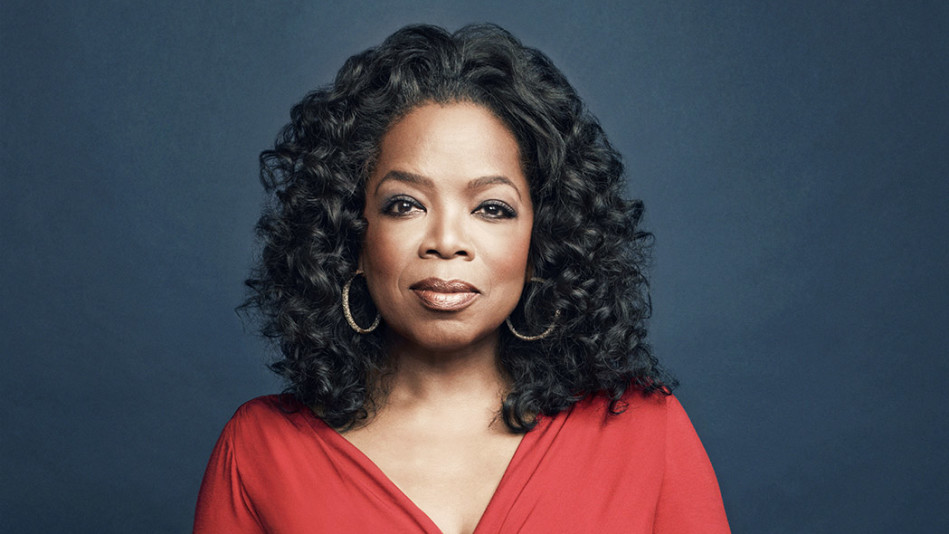

Display aligned face


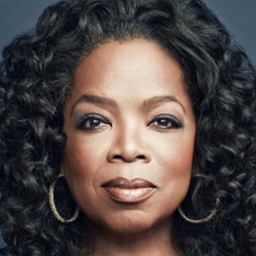

In [2]:
from ml4a import image     
from ml4a.utils import face

img = image.load_image('https://static.oprah.com/2016/01/201602-omag-wikfs-949x534.jpg')

image.display(img, title="Display original image")

aligned_img, face_found = face.align_face(img)
image.display(aligned_img, title="Display aligned face")

We use the GLOW model's encoder to encode the resulting center-cropped face image into its corresponding latent vector `z`.

In [3]:
z = glow.encode(aligned_img)

print("z is the encoding of `aligned_img`. It's shape is:", z.shape)

z is the encoding of `aligned_img`. It's shape is: (1, 196608)


We decode the latent vector `z` back to an image. Notice that the decoded image is identical to the original one. In GLOW, the encoding and decoding process are perfectly invertible and there is no loss. The price we pay is an extremely large latent space (196608 dimensions).

Image decoded from latent vector z, identical to original


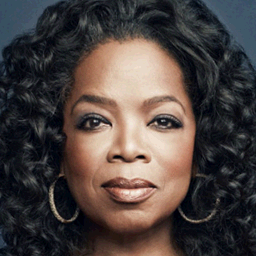

In [4]:
decoded_img = glow.decode(z)
image.display(decoded_img, title="Image decoded from latent vector z, identical to original")

Now let's do some "operations".

By moving in the latent space of `z`, we can make gradual changes to the encoded image. Because `z` is such a high-dimensional space, most directions won't do anything very meaningful, but rather just corrupt the image. 

For instance, here is adding a random vector.

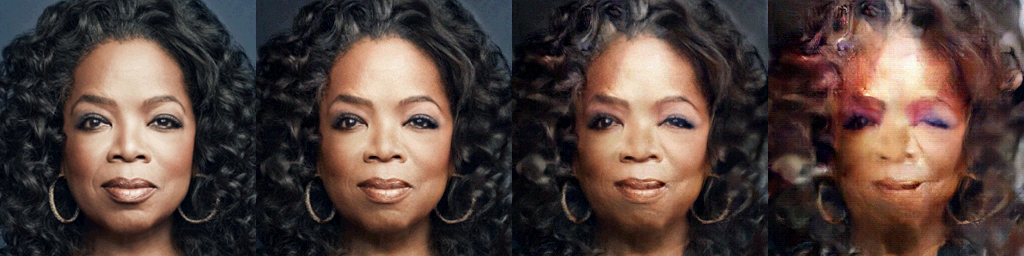

In [5]:
import numpy as np

z_add = np.random.normal(0, 1, z.shape[-1])

# this adds 0.3 * z_add to the z vector we got from the encoded image
z_new = glow.add_attribute(z, z_add, 0.3)

# let's see how the image changes progressively
z_new = [glow.add_attribute(z, z_add, amt) for amt in [0, 0.25, 0.5, 1.0]]
imgs_new = [glow.decode(z_)[0] for z_ in z_new]

image.display(np.concatenate(imgs_new, axis=1))

In order to find a vector of an attribute which is interpretable, a generic strategy is to find many z-vectors of images which have that attribute, and many z-vectors of images which don't have that attribute, average each group together, and take the vector between them. 

Since this strategy is tedious, OpenAI found a bunch of them for us. The z-vectors for these attributes can be found in the map variable `z_manipulate`.

### Known attribute vectors

`5_o_Clock_Shadow`, `Arched_Eyebrows`, `Attractive`, `Bags_Under_Eyes`, 
`Bald`, `Bangs`, `Big_Lips`, `Big_Nose`, `Black_Hair`, `Blond_Hair`, 
`Blurry`, `Brown_Hair`, `Bushy_Eyebrows`, `Chubby`, `Double_Chin`, 
`Eyeglasses`, `Goatee`, `Gray_Hair`, `Heavy_Makeup`, `High_Cheekbones`, 
`Male`, `Mouth_Slightly_Open`, `Mustache`, `Narrow_Eyes`, `No_Beard`, 
`Oval_Face`, `Pale_Skin`, `Pointy_Nose`, `Receding_Hairline`, `Rosy_Cheeks`, 
`Sideburns`, `Smiling`, `Straight_Hair`, `Wavy_Hair`, `Wearing_Earrings`, 
`Wearing_Hat`, `Wearing_Lipstick`, `Wearing_Necklace`, `Wearing_Necktie` `Young`

You can also list them like this:


In [6]:
attributes = glow.get_attributes()
print(attributes)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


For convenience, `glow.add_attribute` can take one of the tag words for the second argument instead of an actual vector. 

add 1.25 x Blond


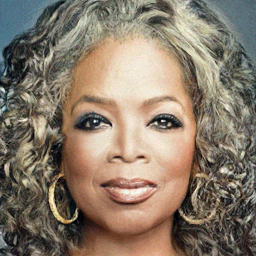

add 1.25 x Goatee


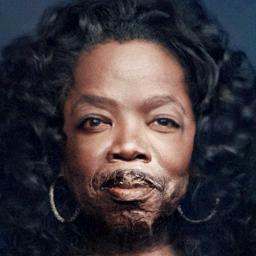

subtract 1.25 x Male


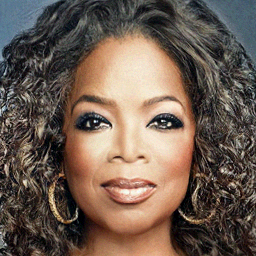

add 1.25 x Smiling


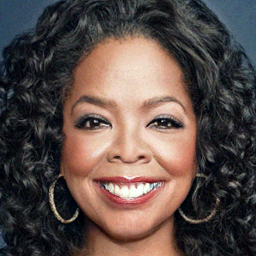

add 1.25 x Eyeglasses


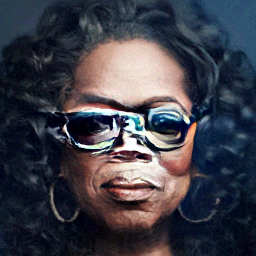

subtract 1.25 x Young (mislabeled)


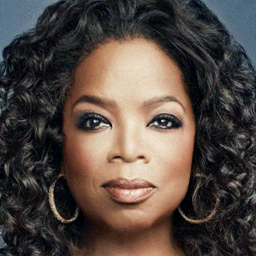

add 1.25 x Young (mislabeled)


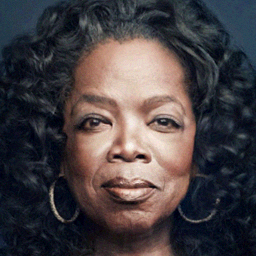

In [7]:

# Blond hair
z_blond = glow.add_attribute(z, 'Blond_Hair', 1.25)
img_blond = glow.decode(z_blond)
image.display(img_blond, title='add 1.25 x Blond')

# Goatee
z_goatee = glow.add_attribute(z, 'Goatee', 1.25)
img_goatee = glow.decode(z_goatee)
image.display(img_goatee, title='add 1.25 x Goatee')

# Female (-male)
z_female = glow.add_attribute(z, 'Male', -1.25)
img_female = glow.decode(z_female)
image.display(img_female, title='subtract 1.25 x Male')

# Smiling
z_smiling = glow.add_attribute(z, 'Smiling', 1.25)
img_smiling = glow.decode(z_smiling)
image.display(img_smiling, title='add 1.25 x Smiling')

# Eyeglasses
z_eyeglasses = glow.add_attribute(z, 'Eyeglasses', 1.25)
img_eyeglasses = glow.decode(z_eyeglasses)
image.display(img_eyeglasses, title='add 1.25 x Eyeglasses')

# Old (-young)   ** note, OpenAI's dataset is mislabeled... `Young` is actually its opposite: an old vector
z_young = glow.add_attribute(z, 'Young', -1.25)
img_young = glow.decode(z_young)
image.display(img_young, title='subtract 1.25 x Young (mislabeled)')

# Young
z_old = glow.add_attribute(z, 'Young', 1.25)
img_old = glow.decode(z_old)
image.display(img_old, title='add 1.25 x Young (mislabeled)')


We can do a latent space traversal through all of these points. We use the vectors from the last step as our endpoints and then generate a long sequence of latent vectors which interpolate through the endpoints, with 30 frames between each consecutive pair.

This will result in a file called `interpolations.mp4`.

In [8]:
from ml4a.utils import video
from ml4a.utils import latents

endpoints = [z_blond, z_goatee, z_female, z_smiling, z_eyeglasses, z_young, z_old]
z = latents.interpolation_walk(endpoints, num_frames_per=30, loop=True)
video.write_from_generator('interpolation.mp4', z, glow.decode)

100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


Another fun thing is to interpolate between two different faces. This will generate a file `face_lerp.mp4`.

In [9]:
face1 = 'https://www.newbeauty.com/wp-content/uploads/2020/02/50812-cherfacemaskpng.png'
face2 = 'https://img1.thelist.com/img/gallery/the-changing-looks-of-lady-gaga/intro-1579195047.jpg'

img1 = image.load_image(face1)
img2 = image.load_image(face2)

aligned_img1, face_found1 = face.align_face(img1)
aligned_img2, face_found2 = face.align_face(img2)

z1 = glow.encode(aligned_img1)
z2 = glow.encode(aligned_img2)

z = latents.interpolation_walk([z1, z2], num_frames_per=80, loop=True)
video.write_from_generator('face_lerp.mp4', z, glow.decode)

100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


We can also just make random faces by sampling latent vectors not far from the average (0). 

random faces


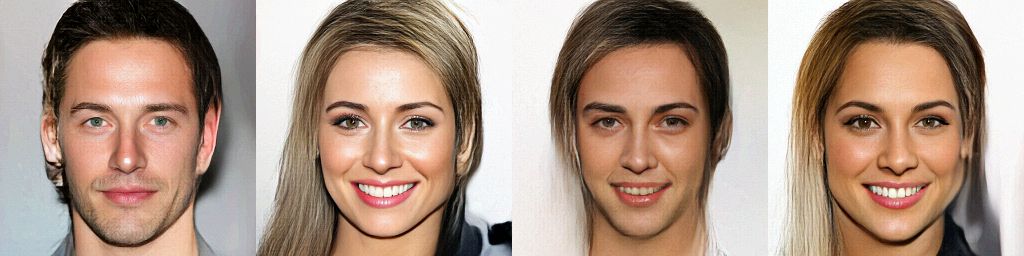

In [10]:
z = [np.random.normal(0, 0.7, 196608) for i in range(4)]
img = glow.decode(z)
image.display(img, title='random faces')